In [1]:
import glob
import imageio
import os
import PIL
import time

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from IPython import display

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import *
from tensorflow.keras.losses import *

from sklearn.metrics import *
from sklearn.model_selection import *

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

def reshape_images(images):
    return images.reshape(images.shape[0], 28, 28, 1).astype('float32')

def normalize_images(images):
    return (images - 127.5) / 127.5

def preprocessing(images):
    return normalize_images(reshape_images(images))

# Normalize the images from [0, 255] to [-1, 1]
X_train = preprocessing(X_train) 
X_test = preprocessing(X_test) 

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

In [4]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

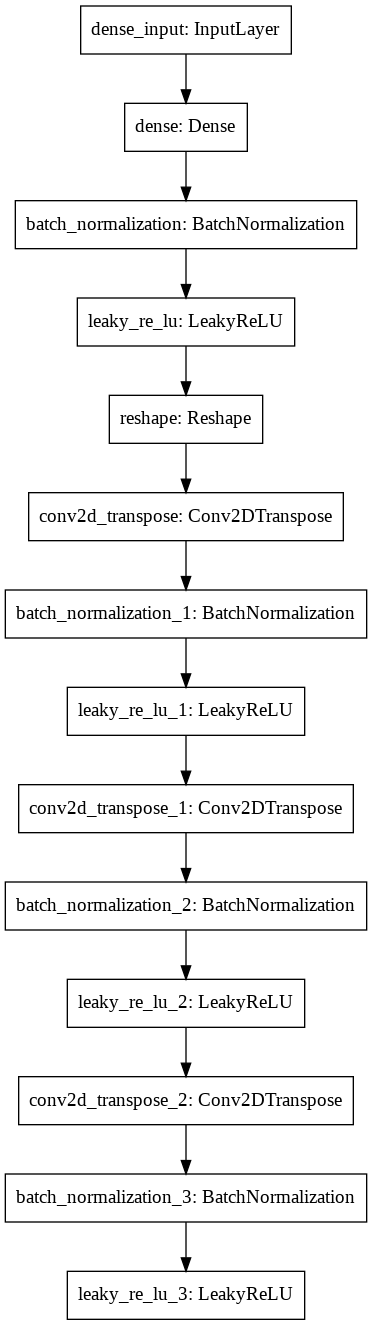

In [5]:
def create_generator():
    model = Sequential([
        Dense(7 * 7 * 256, use_bias = False, input_shape = (noise_dim,)),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((7, 7, 256)),
        # Use Conv2DTranspose for upsampling, to produce an image from random noise
        Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = "same", use_bias = False),
        BatchNormalization(),
        LeakyReLU(),
        # Upsampling for multiple times until we have the desired shape of (28, 28, 1)
        Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = "same", use_bias = False),
        BatchNormalization(),
        LeakyReLU(),
        # Upsampling for multiple times until we have the desired shape of (28, 28, 1)
        Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = "same", use_bias = False, activation = "tanh"),
        BatchNormalization(),
        LeakyReLU(),
    ])
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = create_generator()
plot_model(generator)

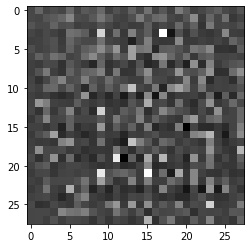

In [6]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

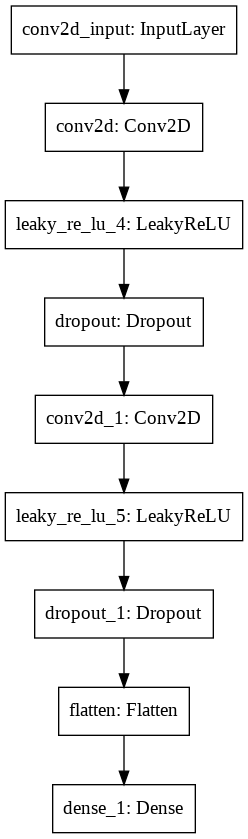

In [7]:
def create_discriminator():
    return Sequential([
        Conv2D(64,
               (5, 5),
               strides = (2, 2),
               padding = "same",
               input_shape = (28, 28, 1)),
        LeakyReLU(),
        Dropout(0.3),

        Conv2D(128,
               (5, 5),
               strides = (2, 2),
               padding = "same"),
        LeakyReLU(),
        Dropout(0.3),

        Flatten(),
        Dense(1)
    ])

discriminator = create_discriminator()
plot_model(discriminator)


In [8]:
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00054604]], dtype=float32)>

In [9]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = BinaryCrossentropy(from_logits = True)

In [10]:
# Discriminator Loss function
def discriminator_loss(real_output, fake_output):
    """ This method quantifies how well the discriminator is able to distinguish real images from fakes.
    
    It compares the discriminator's predictions on real images to an array of 1s, and
    the discriminator's predictions on fake (generated) images to an array of 0s.
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [11]:
def generator_loss(fake_output):
    """ The generator's loss quantifies how well it was able to trick the discriminator.
    
    Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).
    Here, compare the discriminators decisions on the generated images to an array of 1s.
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [14]:
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    """ The training loop begins with generator receiving a random seed as input.
    
    That seed is used to produce an image.
    The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator).
    The loss is calculated for each of these models, and
    the gradients are used to update the generator and discriminator.
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [17]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait = True)
    generate_and_save_images(generator, epochs, seed)

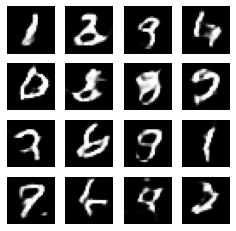

In [39]:
train(train_dataset, EPOCHS)

In [31]:
# Restore the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [20]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

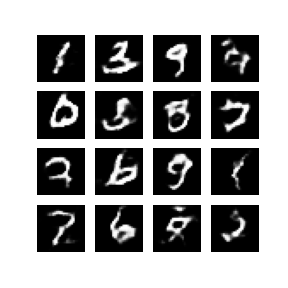

In [36]:
display_image(EPOCHS)

In [40]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
%pip install git+https://github.com/tensorflow/docs


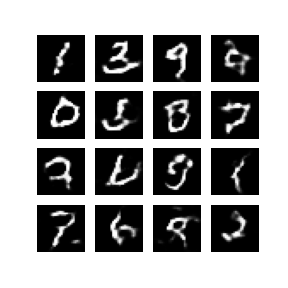

In [41]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)